# Task 3: Statistical Hypothesis Testing for Insurance Risk Analytics

## Objective
Statistically validate or reject key hypotheses about risk drivers to form the basis of our new segmentation strategy.

## Hypotheses to Test
1. **H₀**: There are no risk differences across provinces
2. **H₀**: There are no risk differences between zip codes
3. **H₀**: There are no significant margin (profit) differences between zip codes
4. **H₀**: There are no significant risk differences between Women and Men

## Metrics
- **Risk**: Quantified by Claim Frequency and Claim Severity
- **Claim Frequency**: Proportion of policies with at least one claim
- **Claim Severity**: Average amount of a claim, given a claim occurred
- **Margin**: TotalPremium - TotalClaims

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Import our custom modules
import sys
sys.path.append('../src')

from data_preprocessing import InsuranceDataProcessor
from statistical_utils import StatisticalTester
from hypothesis_testing import InsuranceHypothesisTester

## 1. Data Loading and Preprocessing

In [2]:
# Load the insurance data
# Note: Using the same data from EDA notebook
try:
    df = pd.read_csv("../data/MachineLearningRating_v3.txt", sep="|", low_memory=False)
    print(f"Real data loaded successfully. Shape: {df.shape}")
    
    # For large datasets, sample for faster processing
    if len(df) > 50000:
        print(f"Large dataset detected ({len(df)} records). Sampling 50,000 records for analysis...")
        df = df.sample(n=50000, random_state=42)
        print(f"Sampled data shape: {df.shape}")
        
except FileNotFoundError:
    print("Data file not found. Creating sample data for demonstration...")
    # Create sample data for demonstration
    np.random.seed(42)
    n_samples = 10000
    
    provinces = ['Gauteng', 'Western Cape', 'KwaZulu-Natal', 'Eastern Cape', 
                'Free State', 'Mpumalanga', 'Limpopo', 'North West', 'Northern Cape']
    
    df = pd.DataFrame({
        'PolicyID': range(1, n_samples + 1),
        'Province': np.random.choice(provinces, n_samples, 
                                   p=[0.25, 0.20, 0.15, 0.10, 0.08, 0.08, 0.06, 0.05, 0.03]),
        'PostalCode': np.random.choice(range(1000, 9999), n_samples),
        'Gender': np.random.choice(['Male', 'Female', 'Other'], n_samples, p=[0.48, 0.48, 0.04]),
        'Age': np.random.normal(40, 15, n_samples).clip(18, 80),
        'VehicleType': np.random.choice(['Sedan', 'SUV', 'Hatchback', 'Truck'], n_samples),
    })
    
    # Create correlated premium and claims data with province effects
    province_risk_multiplier = {
        'Gauteng': 1.2, 'Western Cape': 0.9, 'KwaZulu-Natal': 1.1,
        'Eastern Cape': 1.0, 'Free State': 0.8, 'Mpumalanga': 1.0,
        'Limpopo': 0.9, 'North West': 0.95, 'Northern Cape': 0.85
    }
    
    gender_risk_multiplier = {'Male': 1.05, 'Female': 0.98, 'Other': 1.0}
    
    base_premium = 100 + df['Age'] * 2 + np.random.exponential(50, n_samples)
    df['risk_multiplier'] = df['Province'].map(province_risk_multiplier) * df['Gender'].map(gender_risk_multiplier)
    df['TotalPremium'] = base_premium * df['risk_multiplier'] + np.random.normal(0, 20, n_samples)
    df['TotalPremium'] = df['TotalPremium'].clip(10, None)
    
    claim_probability = 0.25 * df['risk_multiplier']
    has_claim = np.random.binomial(1, claim_probability.clip(0, 1), n_samples)
    claim_amounts = np.random.exponential(df['TotalPremium'] * 0.8, n_samples) * has_claim
    df['TotalClaims'] = claim_amounts
    
    df = df.drop(['risk_multiplier'], axis=1)
    print(f"Sample data created. Shape: {df.shape}")

# Display basic info
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
df.head()

Real data loaded successfully. Shape: (1000098, 52)
Large dataset detected (1000098 records). Sampling 50,000 records for analysis...
Sampled data shape: (50000, 52)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 57024 to 346858
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   UnderwrittenCoverID       50000 non-null  int64  
 1   PolicyID                  50000 non-null  int64  
 2   TransactionMonth          50000 non-null  object 
 3   IsVATRegistered           50000 non-null  bool   
 4   Citizenship               50000 non-null  object 
 5   LegalType                 50000 non-null  object 
 6   Title                     50000 non-null  object 
 7   Language                  50000 non-null  object 
 8   Bank                      42644 non-null  object 
 9   AccountType               47977 non-null  object 
 10  MaritalStatus             49603 non-null  obj

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
57024,167791,14494,2015-06-01 00:00:00,False,,Individual,Mr,English,ABSA Bank,Current account,...,No excess,Emergency Charges,Emergency Charges,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,7.082018,0.0
343371,94043,7424,2015-06-01 00:00:00,False,,Individual,Mr,English,First National Bank,Current account,...,No excess,Cleaning and Removal of Accident Debris,Cleaning and Removal of Accident Debris,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,5.800965,0.0
641034,153347,13967,2015-05-01 00:00:00,False,,Individual,Mr,English,Standard Bank,Current account,...,No excess,Keys and Alarms,Keys and Alarms,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,4.895351,0.0
42687,148931,13317,2015-07-01 00:00:00,False,,Individual,Mr,English,NaN,NaN,...,No excess,Keys and Alarms,Keys and Alarms,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,3.218421,0.0
850800,51314,3870,2015-04-01 00:00:00,False,,Private company,Mr,English,First National Bank,Current account,...,No excess,Cleaning and Removal of Accident Debris,Cleaning and Removal of Accident Debris,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,4.672982,0.0


In [3]:
# Initialize the hypothesis tester
hypothesis_tester = InsuranceHypothesisTester(df=df, alpha=0.05)

# Get summary statistics before testing
print("Summary Statistics by Key Variables:")
summaries = hypothesis_tester.processor.get_summary_statistics()

for key, summary in summaries.items():
    print(f"\n{key.upper()} Summary:")
    print(summary)

Summary Statistics by Key Variables:
Starting data cleaning...
Removed 0 rows with missing critical data
Creating risk metrics...
Risk metrics created successfully

PROVINCE Summary:
              HasClaim         ClaimSeverity                Margin             \
                 count    mean          mean         std      mean        std   
Province                                                                        
Eastern Cape      1486  0.0007    12193.7105         NaN   53.7398   350.8314   
Free State         416  0.0024   157520.3596         NaN -317.3118  7695.8482   
Gauteng          19517  0.0030    25599.0280  48295.6006  -13.0812  2947.7774   
KwaZulu-Natal     8461  0.0030    27404.6611  30860.6658   -2.7461  2199.9991   
Limpopo           1195  0.0025    47987.9181  68290.9665  -55.3365  3675.5239   
Mpumalanga        2638  0.0049     6315.7019  16308.2153   24.3657  1183.2128   
North West        7244  0.0017    13080.9364  17321.9471   28.3602   862.4725   
Norther

## 2. Exploratory Data Analysis for Hypothesis Testing

In [4]:
# Prepare data for analysis
hypothesis_data = hypothesis_tester.processor.prepare_hypothesis_data()

# Display data preparation results
for key, data in hypothesis_data.items():
    print(f"{key}: {data.shape[0]} records")
    print(f"  - Claim frequency: {data['HasClaim'].mean():.3f}")
    if 'ClaimSeverity' in data.columns:
        severity_mean = data['ClaimSeverity'].mean()
        print(f"  - Average claim severity: {severity_mean:.2f}")
    print(f"  - Average margin: {data['Margin'].mean():.2f}")
    print()

Preparing data for hypothesis testing...
Starting data cleaning...


Removed 0 rows with missing critical data
Creating risk metrics...
Risk metrics created successfully
PROVINCES dataset: 50000 records
ZIP_CODES dataset: 50000 records
ZIP_CODES_MARGIN dataset: 50000 records
GENDER dataset: 49556 records
provinces: 50000 records
  - Claim frequency: 0.003
  - Average claim severity: 23416.25
  - Average margin: -1.73

zip_codes: 50000 records
  - Claim frequency: 0.003
  - Average claim severity: 23416.25
  - Average margin: -1.73

zip_codes_margin: 50000 records
  - Claim frequency: 0.003
  - Average claim severity: 23416.25
  - Average margin: -1.73

gender: 49556 records
  - Claim frequency: 0.003
  - Average claim severity: 23416.25
  - Average margin: -2.50



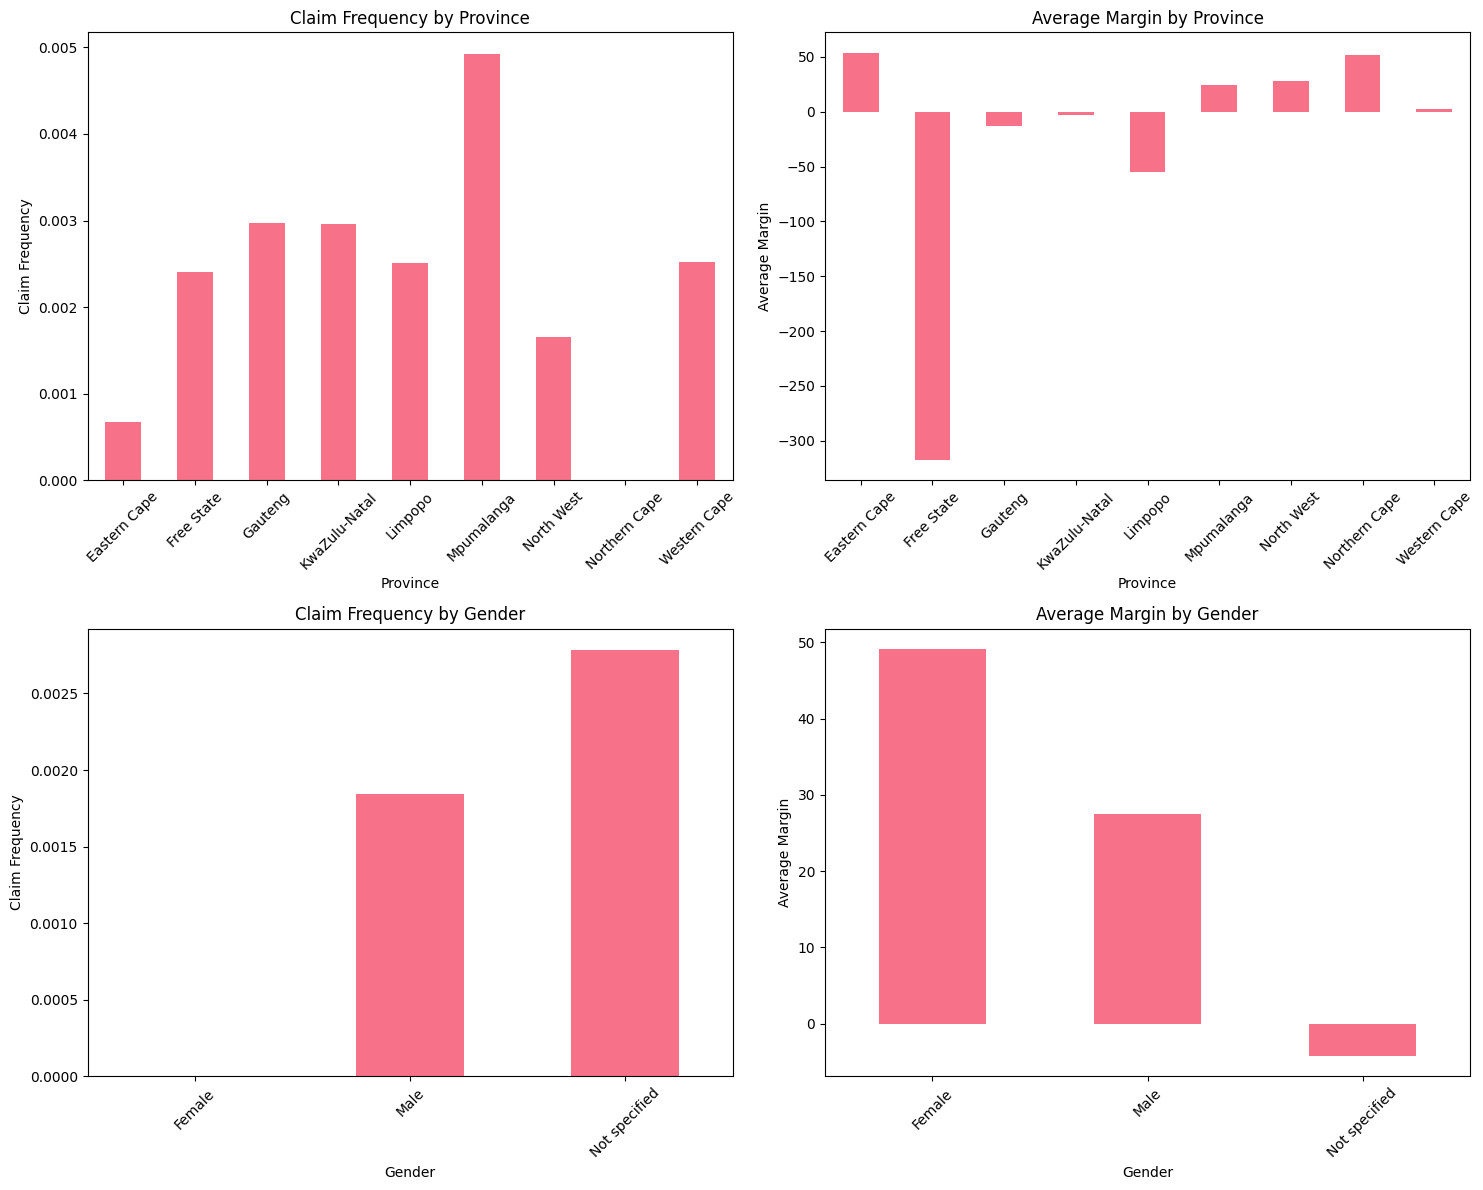

In [5]:
# Visualize key metrics by grouping variables
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Province analysis
province_data = hypothesis_data['provinces']
province_summary = province_data.groupby('Province').agg({
    'HasClaim': 'mean',
    'Margin': 'mean',
    'LossRatio': 'mean'
})

province_summary['HasClaim'].plot(kind='bar', ax=axes[0,0], title='Claim Frequency by Province')
axes[0,0].set_ylabel('Claim Frequency')
axes[0,0].tick_params(axis='x', rotation=45)

province_summary['Margin'].plot(kind='bar', ax=axes[0,1], title='Average Margin by Province')
axes[0,1].set_ylabel('Average Margin')
axes[0,1].tick_params(axis='x', rotation=45)

# Gender analysis
gender_data = hypothesis_data['gender']
gender_summary = gender_data.groupby('Gender').agg({
    'HasClaim': 'mean',
    'Margin': 'mean'
})

gender_summary['HasClaim'].plot(kind='bar', ax=axes[1,0], title='Claim Frequency by Gender')
axes[1,0].set_ylabel('Claim Frequency')
axes[1,0].tick_params(axis='x', rotation=45)

gender_summary['Margin'].plot(kind='bar', ax=axes[1,1], title='Average Margin by Gender')
axes[1,1].set_ylabel('Average Margin')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Hypothesis Testing

In [6]:
# Run all hypothesis tests
print("Running comprehensive hypothesis testing...")
print("=" * 50)

results = hypothesis_tester.run_all_hypothesis_tests()

print("\nHypothesis testing completed!")
print("=" * 50)

Running comprehensive hypothesis testing...
Starting comprehensive hypothesis testing...
Preparing data for hypothesis testing...
Starting data cleaning...
Removed 0 rows with missing critical data
Creating risk metrics...
Risk metrics created successfully
PROVINCES dataset: 50000 records
ZIP_CODES dataset: 50000 records
ZIP_CODES_MARGIN dataset: 50000 records
GENDER dataset: 49556 records
Testing H1: Risk differences across provinces...
Testing H2: Risk differences between zip codes...
Testing H3: Margin differences between zip codes...
Testing H4: Risk differences between genders...
All hypothesis tests completed!

Hypothesis testing completed!


## 4. Results Analysis and Interpretation

In [7]:
# Display results for each hypothesis
hypothesis_names = {
    'H1_provinces': 'H₁: Risk differences across provinces',
    'H2_zip_codes': 'H₂: Risk differences between zip codes',
    'H3_zip_margin': 'H₃: Margin differences between zip codes',
    'H4_gender': 'H₄: Risk differences between genders'
}

for hypothesis_key, hypothesis_name in hypothesis_names.items():
    if hypothesis_key in results:
        result = results[hypothesis_key]
        print(f"\n{'='*60}")
        print(f"{hypothesis_name}")
        print(f"{'='*60}")
        print(f"Null Hypothesis: {result.get('hypothesis', 'N/A')}")
        
        # Display test results
        if 'tests' in result:
            for test_name, test_result in result['tests'].items():
                print(f"\n{test_name.upper()} TEST:")
                print(f"  Test: {test_result.get('test_name', 'N/A')}")
                print(f"  Statistic: {test_result.get('statistic', 'N/A'):.4f}")
                print(f"  P-value: {test_result.get('p_value', 'N/A'):.6f}")
                print(f"  Significant: {test_result.get('significant', 'N/A')}")
                print(f"  Interpretation: {test_result.get('interpretation', 'N/A')}")
        
        # Display conclusion
        if 'conclusion' in result:
            conclusion = result['conclusion']
            print(f"\nCONCLUSION:")
            print(f"  Decision: {conclusion.get('decision', 'N/A')}")
            print(f"  Evidence: {conclusion.get('evidence', 'N/A')}")
        
        print("\n" + "-"*60)


H₁: Risk differences across provinces
Null Hypothesis: H₀: There are no risk differences across provinces

CLAIM_FREQUENCY TEST:
  Test: Chi-Square Test of Independence
  Statistic: 11.8210
  P-value: 0.159372
  Significant: False
  Interpretation: The association is not significant (p=0.1594) with a negligible effect size (Cramér's V=0.0154)

CLAIM_SEVERITY TEST:
  Test: Kruskal-Wallis Test
  Statistic: 18.0488
  P-value: 0.011752
  Significant: True
  Interpretation: The group differences are significant (p=0.0118) with a medium effect size (ε²=0.0870)

LOSS_RATIO TEST:
  Test: Kruskal-Wallis Test
  Statistic: 13.5501
  P-value: 0.094274
  Significant: False
  Interpretation: The group differences are not significant (p=0.0943) with a negligible effect size (ε²=0.0002)

CONCLUSION:
  Decision: REJECT NULL HYPOTHESIS
  Evidence: Significant differences found in: claim_severity

------------------------------------------------------------

H₂: Risk differences between zip codes
Null H

## 5. Summary Report and Business Recommendations

In [8]:
# Display comprehensive summary
if 'summary' in results:
    summary = results['summary']
    
    print("COMPREHENSIVE HYPOTHESIS TESTING SUMMARY")
    print("=" * 50)
    
    print(f"Total hypotheses tested: {summary.get('total_hypotheses_tested', 0)}")
    
    print(f"\nREJECTED HYPOTHESES ({len(summary.get('rejected_hypotheses', []))}):")
    for rejected in summary.get('rejected_hypotheses', []):
        print(f"  • {rejected.get('hypothesis', 'N/A')}")
        print(f"    Evidence: {rejected.get('evidence', 'N/A')}")
    
    print(f"\nFAILED TO REJECT HYPOTHESES ({len(summary.get('failed_to_reject_hypotheses', []))}):")
    for not_rejected in summary.get('failed_to_reject_hypotheses', []):
        print(f"  • {not_rejected.get('hypothesis', 'N/A')}")
        print(f"    Evidence: {not_rejected.get('evidence', 'N/A')}")
    
    print(f"\nBUSINESS RECOMMENDATIONS:")
    for i, recommendation in enumerate(summary.get('business_recommendations', []), 1):
        print(f"  {i}. {recommendation}")

print("\n" + "=" * 50)
print("ANALYSIS COMPLETE")
print("=" * 50)

COMPREHENSIVE HYPOTHESIS TESTING SUMMARY
Total hypotheses tested: 4

REJECTED HYPOTHESES (2):
  • H1_provinces
    Evidence: Significant differences found in: claim_severity
  • H3_zip_margin
    Evidence: Significant differences found in: margin

FAILED TO REJECT HYPOTHESES (2):
  • H2_zip_codes
    Evidence: No significant differences found in any test
  • H4_gender
    Evidence: No significant differences found in any test

BUSINESS RECOMMENDATIONS:
  1. Consider implementing province-specific pricing strategies due to significant risk variations across provinces.
  2. Review pricing strategy by zip code to optimize profit margins and ensure competitive positioning.

ANALYSIS COMPLETE


## 6. Detailed Statistical Results Export

In [9]:
# Create detailed results DataFrame for export
detailed_results = []

for hypothesis_key, hypothesis_name in hypothesis_names.items():
    if hypothesis_key in results:
        result = results[hypothesis_key]
        
        if 'tests' in result:
            for test_name, test_result in result['tests'].items():
                detailed_results.append({
                    'Hypothesis': hypothesis_name,
                    'Test_Type': test_name,
                    'Statistical_Test': test_result.get('test_name', 'N/A'),
                    'Statistic': test_result.get('statistic', np.nan),
                    'P_Value': test_result.get('p_value', np.nan),
                    'Effect_Size': test_result.get('effect_size', np.nan),
                    'Significant': test_result.get('significant', False),
                    'Decision': result.get('conclusion', {}).get('decision', 'N/A')
                })

results_df = pd.DataFrame(detailed_results)
print("Detailed Statistical Results:")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('../results/hypothesis_testing_results.csv', index=False)
print("\nResults saved to '../results/hypothesis_testing_results.csv'")

Detailed Statistical Results:
                              Hypothesis       Test_Type                Statistical_Test     Statistic      P_Value  Effect_Size  Significant                       Decision
   H₁: Risk differences across provinces claim_frequency Chi-Square Test of Independence     11.820973 1.593722e-01     0.015376        False         REJECT NULL HYPOTHESIS
   H₁: Risk differences across provinces  claim_severity             Kruskal-Wallis Test     18.048764 1.175191e-02     0.086998         True         REJECT NULL HYPOTHESIS
   H₁: Risk differences across provinces      loss_ratio             Kruskal-Wallis Test     13.550052 9.427358e-02     0.000181        False         REJECT NULL HYPOTHESIS
  H₂: Risk differences between zip codes claim_frequency Chi-Square Test of Independence      6.313242 7.082044e-01     0.020082        False FAIL TO REJECT NULL HYPOTHESIS
  H₂: Risk differences between zip codes  claim_severity             Kruskal-Wallis Test      7.693820 4.